In [28]:
import pandas
import collections

from nltk.tokenize import TweetTokenizer
from keras.utils import to_categorical

training_df = pandas.read_csv('trainingdata.txt', sep='\t', encoding='latin1')
STANCE = ['FAVOR', 'AGAINST', 'NONE']
all_words = []

for tweet in training_df['Tweet']:
    all_words.extend(TweetTokenizer().tokenize(tweet))
    

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


def words_to_numbers(dictionary, word_arr):
    for i, word in enumerate(word_arr):
        word_arr[i] = dictionary[word] if word in dictionary else 0
    return word_arr


def get_stance_to_num(stance, filter_for):
    # If we only want to train on favor, we need to turn
    # any stance that is AGAINST to NONE so we can
    # build our model that figures out why stuff is in favor
    if filter_for == 'FAVOR':
        return 0 if stance == 'AGAINST' or stance == 'NONE' else 1
    elif filter_for == 'AGAINST':
        return 0 if stance == 'FAVOR' or stance == 'NONE' else 1

def create_training_data(training_data, num_top_words, filter_for='FAVOR'):
    data, count, dictionary, reversed_dictionary = build_dataset(all_words, num_top_words)
    X_data = []
    Y_data = []
    for _, row in training_data.iterrows():
        X_data.append(words_to_numbers(dictionary, TweetTokenizer().tokenize(row['Tweet'])))
        Y_data.append([get_stance_to_num(row['Stance'], filter_for)])
    return X_data, Y_data


### Create the training set

Here we create the training set and pad it out to get everything prepped for the model

In [32]:
from keras.preprocessing import sequence

num_top_words = 5000

X_favor_train, y_favor_train = create_training_data(training_df, num_top_words, 'FAVOR')
X_against_train, y_against_train = create_training_data(training_df, num_top_words, 'AGAINST')

# Magic number that I computed so I can pad out the input arrays
longest_row = 37
# Lets pad those suckers out
X_favor_train = sequence.pad_sequences(X_train, maxlen=longest_row, padding='post')
X_against_train = sequence.pad_sequences(X_train, maxlen=longest_row, padding='post')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 37, 128)           640000    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 37, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 197       
Total params: 894,997
Trainable params: 894,997
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 37, 128)           640000    
_________________________________________________________________

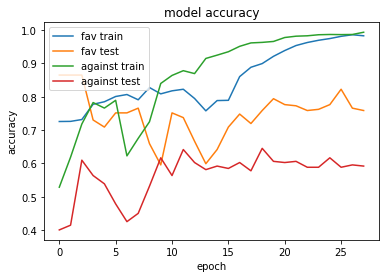

In [33]:
import numpy
import keras
import matplotlib.pyplot as plt
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create the model
embed_dim = 128
lstm_out = 196


def create_model():
    model = Sequential()
    model.add(Embedding(num_top_words, embed_dim, input_length=longest_row))
    model.add(keras.layers.SpatialDropout1D(0.2))
    model.add(LSTM(lstm_out, recurrent_dropout=0.5, dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model
    
    
fav_model = create_model()
against_model = create_model()

fav_history = fav_model.fit(X_favor_train, y_favor_train, epochs=28, validation_split=0.1, batch_size=16, verbose=1)
against_history = against_model.fit(X_against_train, y_against_train, epochs=28, validation_split=0.1, batch_size=16, verbose=1)

# summarize history for accuracy
plt.plot(fav_history.history['acc'])
plt.plot(fav_history.history['val_acc'])
plt.plot(against_history.history['acc'])
plt.plot(against_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['fav train', 'fav test', 'against train', 'against test'], loc='upper left')
plt.show()


In [9]:
# Evaluate F-score
def listOfTopics(dataframe):
    listOfTopics = []
    for row in traindf['Target']:
        if row not in listOfTopics:
            listOfTopics.append(row)
    return listOfTopics


traindf = pandas.read_csv('./trainingData.txt', sep='\t', encoding='latin1')
print(traindf.head())
testdf = pandas.read_csv('./subtaskA-testdata-gold.txt', sep='\t', encoding='latin1')

X_gold, _ = create_training_data(testdf, num_top_words)
X_gold = sequence.pad_sequences(X_gold, maxlen=longest_row, padding='post')

predictions = model.predict(X_gold)
gold_predictions = [0] * len(predictions)

for idx, prediction in enumerate(predictions):
    gold_predictions[idx] = STANCE[prediction.tolist().index(max(prediction))]

outdf = pandas.DataFrame(columns=['ID','Target','Tweet','Stance'])

for topic in listOfTopics(traindf):
    testExtract = testdf.loc[testdf['Target'] == topic]
    testCorpus = list(map(lambda x: x[:-6], list(testExtract['Tweet'])))

    ID = list(map(lambda x: str(x), list(testExtract['ID'])))
    s = zip(ID, list(testExtract['Target']), testCorpus, list(gold_predictions))

    for x in s:
        outdf.loc[len(outdf)] = list(x)

outdf.set_index('ID')
outdf.to_csv('output.txt', sep='\t', index=False)

    ID   Target                                              Tweet   Stance
0  101  Atheism  dear lord thank u for all of ur blessings forg...  AGAINST
1  102  Atheism  Blessed are the peacemakers, for they shall be...  AGAINST
2  103  Atheism  I am not conformed to this world. I am transfo...  AGAINST
3  104  Atheism  Salah should be prayed with #focus and #unders...  AGAINST
4  105  Atheism  And stay in your houses and do not display you...  AGAINST
